# Wildlife In-Filling

**Author**: Medha Agarwal

**Last modified**: May 01, 2024

In this notebook, we conduct missing data in-filling for acceleration data using autoregressive flows.

In [1]:
# System & OS

import sys
import os
import time
import warnings
import random
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports

from data.Vectronics.filter_dataframes import (filter_data)

from data.matching_data.utils import VECTRONICS_METADATA_PATH, AWD_VECTRONICS_PATHS, id_mapping

from normalizing_flows import MAF, MADE
from flow_utils import (format_time,
                    train_one_epoch_maf,
                    train_one_epoch_made,
                    test_maf, test_made,
                    val_maf, val_made)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt


We define some hyperparameters for in-filling

In [129]:
CONTEXT_DURATION = 10
SAMPLING_RATE = 16
NUM_HALF_DAYS = 6
TEST_TRAIN_RATIO = 0.2
BATCH_SIZE = 128
DEVICE = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [130]:
# load metadata and annotations
metadata = pd.read_csv(VECTRONICS_METADATA_PATH) 
filter_profile = {'dog ID': ['palus',],
                   'year': None,
                   'UTC Date [yyyy-mm-dd]': None,
                   'am/pm': None,
                   'half day [yyyy-mm-dd_am/pm]': None,
                   'avg temperature [C]': None}

filtered_metadata = metadata.iloc[filter_data(metadata, filter_profile)]
print(f'Total number of half days: {len(filtered_metadata)}')


Total number of half days: 744


In [131]:
cols = ['dog ID', 'UTC Date [yyyy-mm-dd]', 'am/pm',  'half day [yyyy-mm-dd_am/pm]', 'acc_x', 'acc_y', 'acc_z']
X = torch.empty(1, SAMPLING_RATE*CONTEXT_DURATION)
metadata_count = 0
for i, row in metadata.iterrows():
        segment = pd.read_csv(row['file path'])
        print(f'Shape of data at half day {i+1} -- {segment.shape}')
        metadata_count += 1
        
        for j in range(len(segment)//(SAMPLING_RATE*CONTEXT_DURATION)):
                acc_chunk = segment.loc[(SAMPLING_RATE*CONTEXT_DURATION*j):(SAMPLING_RATE*CONTEXT_DURATION*(j+1) -1 ), 'Acc X [g]']
                acc_chunk = torch.tensor(acc_chunk.values, dtype=torch.float32).unsqueeze(0)
                X = torch.cat((X, acc_chunk), dim=0)

        if metadata_count == NUM_HALF_DAYS:
                break

X = X[1:]
X_train = X[:-int(TEST_TRAIN_RATIO*len(X))]
X_test = X[-int(TEST_TRAIN_RATIO*len(X)):]
print(f'X train shape - {X_train.shape}\nX test shape - {X_test.shape}')

Shape of data at half day 1 -- (56, 9)
Shape of data at half day 2 -- (686766, 9)
Shape of data at half day 3 -- (691068, 9)
Shape of data at half day 4 -- (691264, 9)
Shape of data at half day 5 -- (691042, 9)
Shape of data at half day 6 -- (891, 9)
X train shape - torch.Size([13804, 160])
X test shape - torch.Size([3451, 160])


## Learn normalizing flow from Vectronics to Gaussian

In [133]:
n_mades = 3
hidden_dims = [8]
lr = 1e-4
weight_decay = 1e-4
random_order = False
patience = 500
seed = 0
model_name = 'maf'
epochs = 200

In [134]:
n_in = X_train.shape[1]

if model_name.lower() == "maf":
    flow = MAF(n_in, n_mades, hidden_dims)
elif model_name.lower() == "made":
    flow = MADE(n_in, hidden_dims, random_order=random_order, seed=seed, gaussian=True)

optimiser = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)
save_dir = f'results/{model_name}'
os.makedirs(save_dir, exist_ok=True)
save_name = os.path.join(save_dir, 'flow.pt')

In [135]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=BATCH_SIZE, shuffle=True)

In [136]:
train_losses, val_losses = [], []
max_loss = np.inf

print("Training...")
t0 = time.time()
for epoch_i in tqdm(range(epochs)):

    if model_name == "maf":
        train_loss = train_one_epoch_maf(flow, optimiser, train_loader)
        val_loss = val_maf(flow, test_loader)
    elif model_name == "made":
        train_loss = train_one_epoch_made(flow, optimiser, train_loader)
        val_loss = val_made(flow, test_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch_i+1) % 100 == 0:
        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
        print(f"Training and validation takes: {format_time(time.time() - t0)}.")
        print("")
        print(f"Average train loss: {train_loss}")
        print(f"Average validation loss: {val_loss}")

    if val_loss < max_loss:
        i = 0
        max_loss = val_loss
        torch.save(
            flow, save_name
        )  
    else:
        i += 1

    if i >= patience:
        print("Patience counter: {}/{}\n Terminate training!".format(i, patience))
        break

print("Training complete!")
print(f"Took {format_time(time.time() - t0)}.")



Training...


 50%|█████     | 100/200 [01:03<01:04,  1.56it/s]


======== Epoch 100 / 200 ========
Training and validation takes: 0:01:03.

Average train loss: -230.93505350748697
Average validation loss: -255.13511904879812


100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


======== Epoch 200 / 200 ========
Training and validation takes: 0:02:08.

Average train loss: -255.7943526373969
Average validation loss: -268.9324296074168
Training complete!
Took 0:02:08.


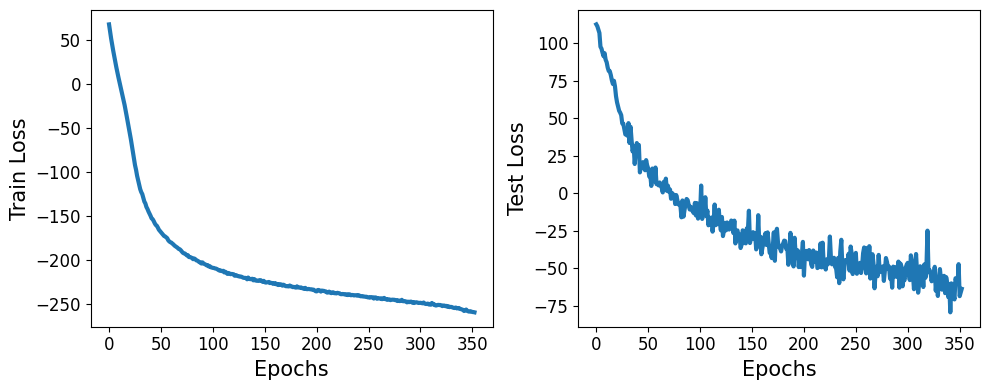

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(train_losses)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Train Loss')

axs[1].plot(val_losses)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Test Loss')

plt.tight_layout()
plt.show()

Now let us normalize the test data.

In [127]:
with torch.no_grad():
    normalized_X_test,_ = flow(X_test)

# normalized_X_test = (X_test - normalized_X_test[:,:160])/torch.sqrt(normalized_X_test[:,160:])
normalized_X_test.shape

torch.Size([2586, 160])

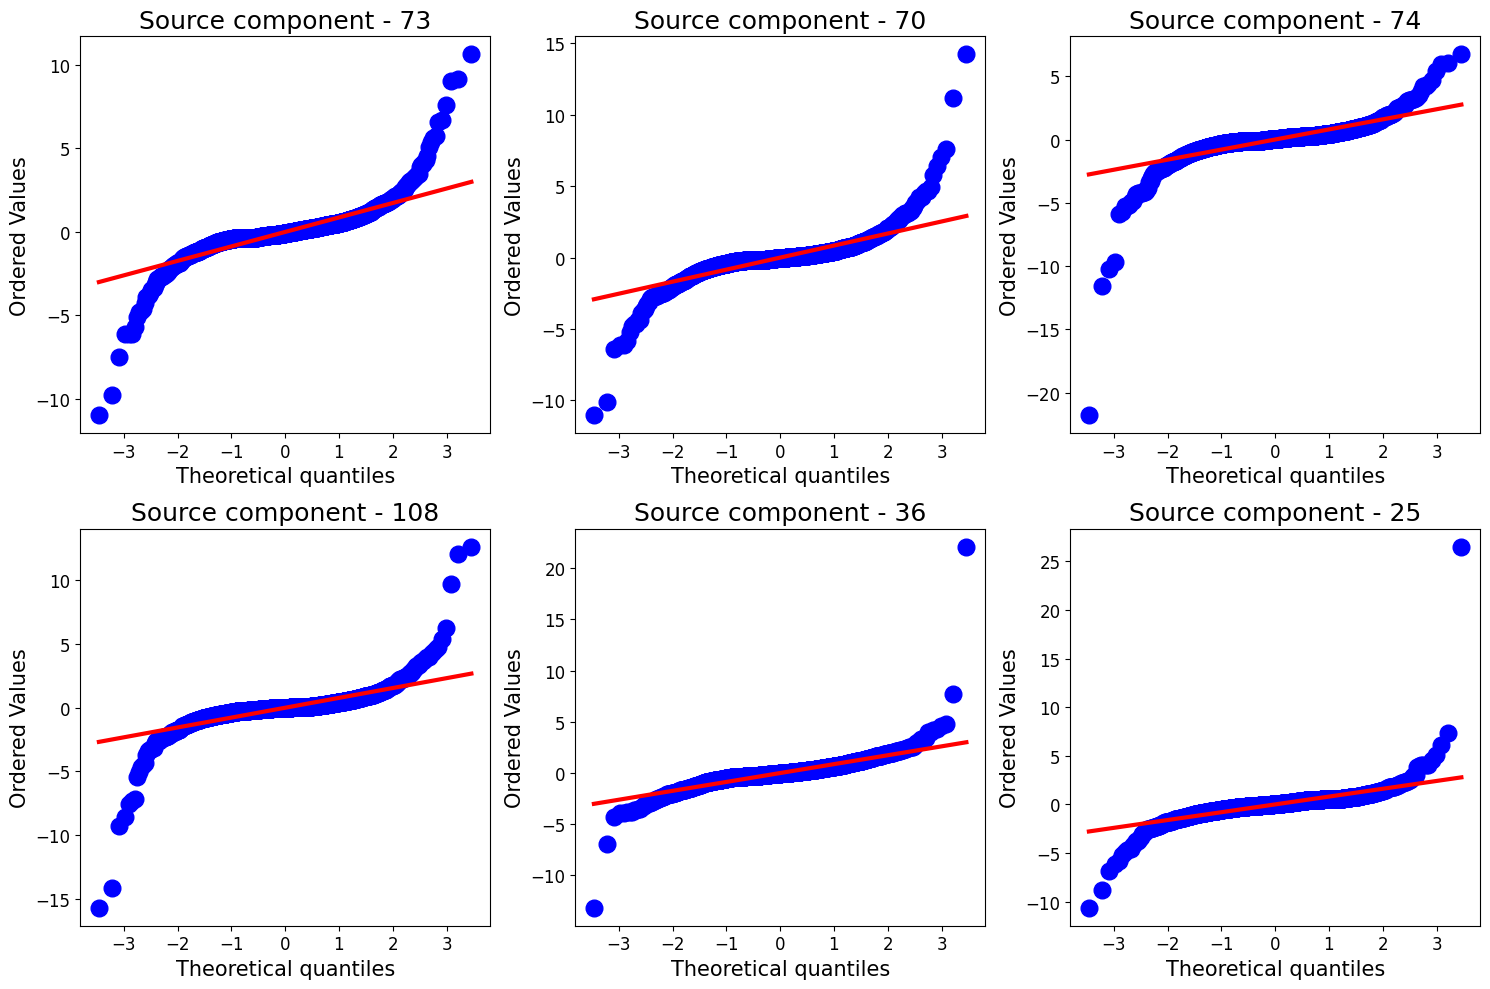

In [128]:
from scipy import stats

comps = np.random.choice(normalized_X_test.shape[1], 6, replace=False) 

# Create subplots for multiple Q-Q plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i,c in enumerate(comps):

    stats.probplot(normalized_X_test[:,c], dist="norm", plot=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Source component - {c}', fontsize=18)

plt.tight_layout()
plt.show()
